<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Pareto_NBD_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 10.2 MB/s 


In [2]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import plotly.express as px
import xlrd
import pandas as pd
import warnings
import lifetimes
import dill as pickle
from sklearn.cluster import KMeans
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt
warnings.filterwarnings("ignore")
import datetime
np.random.seed(42)

In [3]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [4]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01 07:45:00,1.25,13085,United Kingdom


In [5]:
data["TotalPrice"] = data["Quantity"]*data["Price"]

In [6]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format="%Y-%m-%d %H:%M:%S")
data['InvoiceDate'] = data.InvoiceDate.dt.date
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'].describe()

count                  779428
unique                    604
top       2021-11-06 00:00:00
freq                     3340
first     2019-12-01 00:00:00
last      2021-12-09 00:00:00
Name: InvoiceDate, dtype: object

In [7]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01,1.25,13085,United Kingdom,30.0


In [8]:
from datetime import datetime

In [9]:
# The last purchase made in the dataset was on August 29, 2018, so we will use that date as our current 
# date to simulate an immediate study of the company's transactions.

today = '2021-12-09'
date_today = datetime.strptime(today, '%Y-%m-%d')

In [10]:
r = data.groupby('CustomerID').agg(['min', 'max'])['InvoiceDate']
r['recency'] = r['max'] - r['min']

In [11]:
r['T'] = date_today - r['min']
r = r[['recency', 'T']]

# Let's take a look at our new variables
r

,recency,T
CustomerID,,
12346,401 days,726 days
12347,402 days,404 days
12348,363 days,438 days
12349,571 days,589 days
12350,0 days,310 days
...,...,...
18283,656 days,659 days
18284,0 days,431 days
18285,0 days,661 days


In [12]:
aggregations = {
    'InvoiceDate':'count',
    'TotalPrice': 'sum'}
f = data.groupby('CustomerID').agg(aggregations)
f['frequency'] = f['InvoiceDate'] - 1
f = f[['frequency']]

In [13]:
# Let's create our final table joining both

rfm_summary = pd.merge(r,f, left_index=True, right_index=True)
rfm_summary

,recency,T,frequency
CustomerID,,,
12346,401 days,726 days,33
12347,402 days,404 days,221
12348,363 days,438 days,50
12349,571 days,589 days,174
12350,0 days,310 days,16
...,...,...,...
18283,656 days,659 days,937
18284,0 days,431 days,27
18285,0 days,661 days,11


In [14]:
from lifetimes.utils import summary_data_from_transaction_data

rfm_summary = summary_data_from_transaction_data(data, customer_id_col='CustomerID', datetime_col='InvoiceDate', 
                                    monetary_value_col ='TotalPrice', observation_period_end='2021-12-09', 
                                    datetime_format='%Y-%m-%d', freq='W')
rfm_summary

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,7.0,58.0,104.0,11066.637143
12347,7.0,58.0,58.0,615.714286
12348,4.0,52.0,63.0,449.310000
12349,3.0,81.0,84.0,1120.056667
12350,0.0,0.0,44.0,0.000000
...,...,...,...,...
18283,18.0,94.0,94.0,142.666667
18284,0.0,0.0,62.0,0.000000
18285,0.0,0.0,94.0,0.000000


In [15]:
rfm_summary.reset_index(inplace = True)

In [16]:
rfm_summary.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,CustomerID,frequency,recency,T,monetary_value
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,4.324600,39.105818,67.759782,321.692193
std,1715.572666,7.589976,37.049205,31.928159,2264.337666
min,12346.000000,0.000000,0.000000,0.000000,0.000000
1%,12405.770000,0.000000,0.000000,2.000000,0.000000
10%,12936.700000,0.000000,0.000000,13.000000,0.000000
25%,13833.250000,0.000000,0.000000,45.000000,0.000000
50%,15314.500000,2.000000,32.000000,76.000000,209.985000
75%,16797.750000,5.000000,73.000000,96.000000,373.748250
90%,17696.300000,11.000000,96.000000,104.000000,605.203600


**Visualizing our Customers**

In [17]:
px.histogram(rfm_summary, x=rfm_summary['frequency'],title='Frequency of purchase',
                   labels={'frequency':'Frequency'}, 
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

In [18]:
px.histogram(rfm_summary, x=rfm_summary['recency'],title='Recency of purchase',
                   labels={'recency':'Recency'}, nbins=50,
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

In [19]:
px.histogram(rfm_summary, x=rfm_summary['T'],title='Time from first purchase',
                   labels={'T':'Weeks'}, 
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

In [20]:
px.histogram(rfm_summary, x=rfm_summary['monetary_value'],title='Amount of purchase',
                   labels={'monetary_value':'Monetary Value'}, 
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

**Pareto/NBD Model**

In [21]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 11.833428474586778
Predicted Purchase R2 Score: 0.2965414939304376
Predicted Purchase Root Mean Squared Error: 3.4399750688902935
Predicted Purchase Average Purchases Error: 1.078610854222941


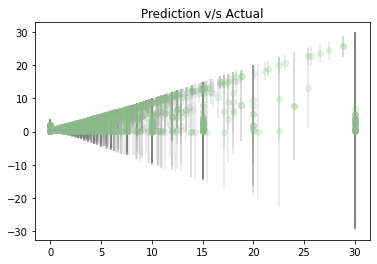

In [22]:
get_model(rfm_summary, 0.001, 30)

In [23]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [24]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"], verbose=True)
print(pareto_model)

Optimize function with Nelder-Mead
Optimization terminated successfully.
         Current function value: -33985.053098
         Iterations: 305
         Function evaluations: 517
<lifetimes.ParetoNBDFitter: fitted with 5878 subjects, alpha: 11.91, beta: 60.96, r: 0.80, s: 0.18>


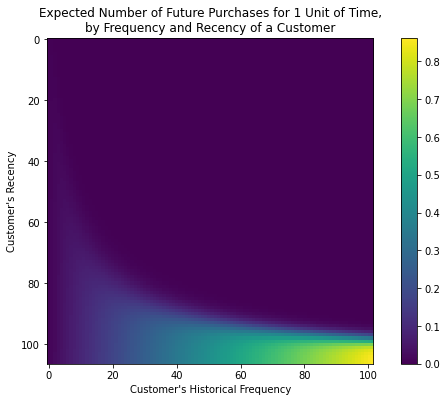

In [25]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

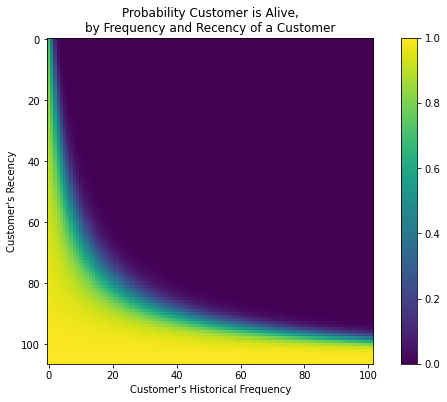

In [26]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [27]:
pareto_result = rfm_summary.copy()

In [28]:
pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [29]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346,7.0,58.0,104.0,11066.637143,0.429333,0.570667
1,12347,7.0,58.0,58.0,615.714286,0.000000,1.000000
2,12348,4.0,52.0,63.0,449.310000,0.024618,0.975382
3,12349,3.0,81.0,84.0,1120.056667,0.003997,0.996003
4,12350,0.0,0.0,44.0,0.000000,0.156043,0.843957


In [30]:
t = 4 # Weeks for a future transaction 
pareto_result["predicted_purchases_4week"] = round(pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"]),2)

In [31]:
pareto_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases_4week
0,12346,7.0,58.0,104.0,11066.637143,0.429333,0.570667,0.15
1,12347,7.0,58.0,58.0,615.714286,0.000000,1.000000,0.44
2,12348,4.0,52.0,63.0,449.310000,0.024618,0.975382,0.25
3,12349,3.0,81.0,84.0,1120.056667,0.003997,0.996003,0.16
4,12350,0.0,0.0,44.0,0.000000,0.156043,0.843957,0.05
...,...,...,...,...,...,...,...,...
5873,18283,18.0,94.0,94.0,142.666667,0.000000,1.000000,0.71
5874,18284,0.0,0.0,62.0,0.000000,0.212553,0.787447,0.03
5875,18285,0.0,0.0,94.0,0.000000,0.297715,0.702285,0.02
5876,18286,1.0,35.0,103.0,833.480000,0.195675,0.804325,0.05


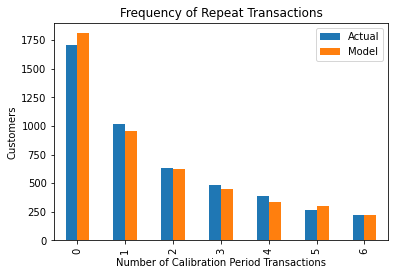

In [32]:
plot_period_transactions(pareto_model)

In [33]:
pareto_result["predicted_purchases_8week"]  = round(pareto_model.predict(8, pareto_result['frequency'], pareto_result['recency'], pareto_result['T']), 2)
pareto_result["predicted_purchases_12week"]  = round(pareto_model.predict(12, pareto_result['frequency'], pareto_result['recency'], pareto_result['T']), 2)

In [34]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases_4week,predicted_purchases_8week,predicted_purchases_12week
0,12346,7.0,58.0,104.0,11066.637143,0.429333,0.570667,0.15,0.31,0.46
1,12347,7.0,58.0,58.0,615.714286,0.000000,1.000000,0.44,0.89,1.33
2,12348,4.0,52.0,63.0,449.310000,0.024618,0.975382,0.25,0.50,0.74
3,12349,3.0,81.0,84.0,1120.056667,0.003997,0.996003,0.16,0.31,0.47
4,12350,0.0,0.0,44.0,0.000000,0.156043,0.843957,0.05,0.10,0.14


**Validating our model**

In [35]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2021-06-08',
                                                  observation_period_end = '2021-12-09')

In [36]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [37]:
pareto_val = pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"], verbose=True)
print(pareto_val)

Optimize function with Nelder-Mead
Optimization terminated successfully.
         Current function value: -22279.029661
         Iterations: 313
         Function evaluations: 522
<lifetimes.ParetoNBDFitter: fitted with 4966 subjects, alpha: 74.35, beta: 1509.71, r: 0.74, s: 0.63>


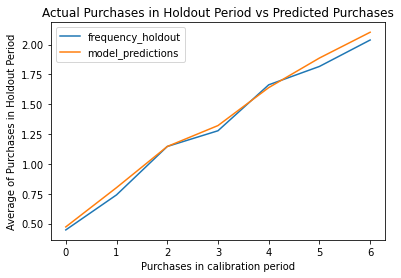

In [38]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [39]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [40]:
pareto_result["actual30"] = pareto_result["frequency"]/pareto_result["recency"]*30

In [41]:
pareto_result["actual30"].fillna(0, inplace = True)

In [42]:
pareto_result["error"] = pareto_result["actual30"]-pareto_result["predicted_purchases_4week"]

In [43]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases_4week,predicted_purchases_8week,predicted_purchases_12week,actual30,error
0,12346,7.0,58.0,104.0,11066.637143,0.429333,0.570667,0.15,0.31,0.46,3.620690,3.470690
1,12347,7.0,58.0,58.0,615.714286,0.000000,1.000000,0.44,0.89,1.33,3.620690,3.180690
2,12348,4.0,52.0,63.0,449.310000,0.024618,0.975382,0.25,0.50,0.74,2.307692,2.057692
3,12349,3.0,81.0,84.0,1120.056667,0.003997,0.996003,0.16,0.31,0.47,1.111111,0.951111
4,12350,0.0,0.0,44.0,0.000000,0.156043,0.843957,0.05,0.10,0.14,0.000000,-0.050000


In [44]:
def get_metrics(true, predicted, error):
    
    print("Mean Squared Error: %s"%(mean_squared_error(true, predicted)))
    print("Root Mean Squared Error: %s"%(sqrt(mean_squared_error(true, predicted))))
    print("R2 Score: %s"%(r2_score(true, predicted)))
    
    sns.scatterplot(true, predicted, size = error, color = "darkolivegreen")
    plt.title("Actual Purchase v/s Predicted Purchase")
    plt.show()

Mean Squared Error: 22.072797149973937
Root Mean Squared Error: 4.698169553131724
R2 Score: -0.3121553860103401


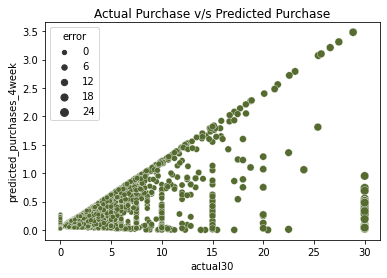

In [45]:
get_metrics(pareto_result["actual30"], pareto_result["predicted_purchases_4week"], pareto_result["error"])

In [46]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(pareto_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

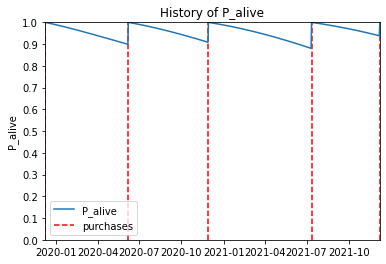

In [47]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [48]:
idx = pareto_result[(pareto_result["frequency"] <= 0.0)]

In [49]:
idx = idx.index

In [50]:
ggf_filter = pareto_result.drop(idx, axis = 0)

In [51]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [52]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [53]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

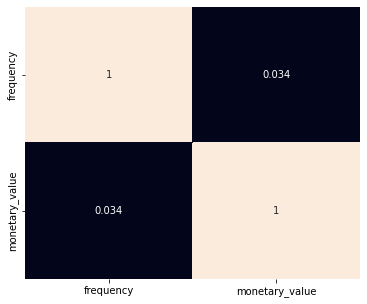

In [54]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [55]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [56]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4172 subjects, p: 1.02, q: 0.18, v: 0.93>

In [57]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.018717,0.024570,0.970559,1.066874
q,0.178256,0.002986,0.172403,0.184109
v,0.931550,0.025540,0.881491,0.981610


In [58]:
ggf_filter["expected_avg_sales_"] = round(ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"]), 2)
ggf_filter.sort_values(by='expected_avg_sales_', ascending=False)

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases_4week,predicted_purchases_8week,predicted_purchases_12week,actual30,error,expected_avg_sales_
4061,16446,1.0,29.0,29.0,168469.600,0.000000,1.000000,0.17,0.35,0.52,1.034483,0.864483,871307.41
3371,15749,1.0,13.0,47.0,21535.900,0.137857,0.862143,0.10,0.21,0.31,2.307692,2.207692,111385.66
189,12536,1.0,2.0,8.0,8322.120,0.022400,0.977600,0.35,0.70,1.04,15.000000,14.650000,43045.73
11,12357,1.0,50.0,55.0,6207.670,0.008483,0.991517,0.11,0.21,0.32,0.600000,0.490000,32110.07
1726,14091,1.0,6.0,100.0,4010.080,0.523699,0.476301,0.03,0.06,0.09,5.000000,4.970000,20744.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,13307,2.0,68.0,85.0,22.800,0.028984,0.971016,0.11,0.22,0.33,0.882353,0.772353,38.99
5010,17408,2.0,50.0,73.0,22.700,0.052214,0.947786,0.12,0.25,0.37,1.200000,1.080000,38.82
5408,17816,5.0,99.0,104.0,14.296,0.006297,0.993703,0.20,0.40,0.59,1.515152,1.315152,17.27
5627,18037,13.0,84.0,106.0,11.190,0.127445,0.872555,0.41,0.81,1.22,4.642857,4.232857,12.01


In [59]:
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Mean Squared Error: 121763021.90000704
Root Mean Squared Error: 11034.628308194484
R2 Score: -15.998928369890514


In [60]:
ggf_filter["predicted_clv"] = round(ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 4,
                                                       freq = 'D',
                                                       discount_rate = 0.01))

In [61]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
4061,16446,1681634.0
5692,18102,378137.0
2277,14646,342329.0
1789,14156,202266.0
2538,14911,187530.0


In [62]:
# Assuming 5% of Profit Margin
ggf_filter["profit_margin"] = ggf_filter["predicted_clv"]*0.05

In [63]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [64]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

**CUSTOMER SEGMENTATION USING PREDICTED CLV**

In [65]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases_4week,predicted_purchases_8week,predicted_purchases_12week,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
0,12346,7.0,58.0,104.0,11066.637143,0.429333,0.570667,0.15,0.31,0.46,3.620690,3.470690,12508.15,58144.0,2907.20
1,12347,7.0,58.0,58.0,615.714286,0.000000,1.000000,0.44,0.89,1.33,3.620690,3.180690,696.06,4658.0,232.90
2,12348,4.0,52.0,63.0,449.310000,0.024618,0.975382,0.25,0.50,0.74,2.307692,2.057692,563.10,2213.0,110.65
3,12349,3.0,81.0,84.0,1120.056667,0.003997,0.996003,0.16,0.31,0.47,1.111111,0.951111,1532.40,4141.0,207.05
6,12352,8.0,51.0,56.0,338.261250,0.011134,0.988866,0.51,1.02,1.52,4.705882,4.195882,376.32,2880.0,144.00


In [66]:
col = ["predicted_purchases_4week", "expected_avg_sales_", "predicted_clv", "profit_margin"]

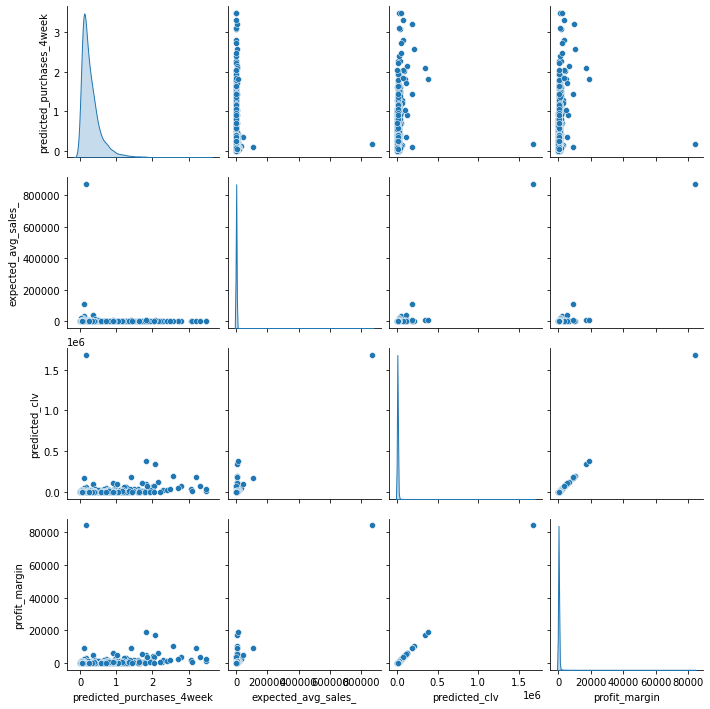

In [67]:
sns.pairplot(ggf_filter[col], diag_kind = "kde")

In [68]:
new_df = ggf_filter[col]
print(new_df)

      predicted_purchases_4week  expected_avg_sales_  predicted_clv  \
0                          0.15             12508.15        58144.0   
1                          0.44               696.06         4658.0   
2                          0.25               563.10         2213.0   
3                          0.16              1532.40         4141.0   
6                          0.51               376.32         2880.0   
...                         ...                  ...            ...   
5871                       0.07               422.81          533.0   
5872                       0.24               407.40          879.0   
5873                       0.71               149.41         1904.0   
5876                       0.05              4315.47         4663.0   
5877                       0.24               742.20         3112.0   

      profit_margin  
0           2907.20  
1            232.90  
2            110.65  
3            207.05  
6            144.00  
...            

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(new_df)
scaled

array([[-0.47923027,  0.83788377,  1.90571257,  1.90571257],
       [ 0.43457764, -0.02711235,  0.02557316,  0.02557316],
       [-0.16412409, -0.03684898, -0.06037346, -0.06037346],
       ...,
       [ 1.28536431, -0.06714338, -0.07123543, -0.07123543],
       [-0.79433644,  0.23793605,  0.02574892,  0.02574892],
       [-0.19563471, -0.02373353, -0.02877182, -0.02877182]])

In [70]:
inertia = []

for i in range(1, 11):
    kmeans  = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

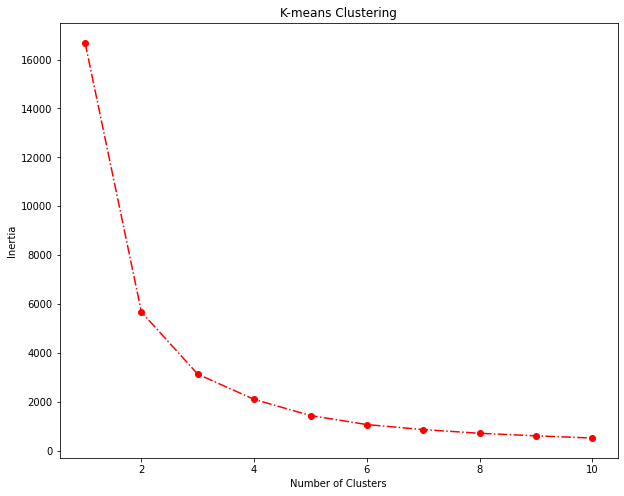

In [71]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), inertia, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering')
plt.show()

In [72]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(scaled)

KMeans(n_clusters=4, random_state=42)

In [73]:
labels = kmeans.labels_

In [74]:
new_df['cluster'] = labels
new_df['cluster'].value_counts()

0    4137
3      28
2       6
1       1
Name: cluster, dtype: int64

In [79]:
df_segm_analysis = new_df.groupby(['cluster']).mean()
df_segm_analysis

,predicted_purchases_4week,expected_avg_sales_,predicted_clv,profit_margin
cluster,,,,
0,0.291337,789.616986,2.766777e+03,138.338869
1,0.170000,871307.410000,1.681634e+06,84081.700000
2,1.865000,24465.570000,2.452780e+05,12263.900000
3,1.560000,5851.594643,6.423486e+04,3211.742857


In [77]:
df_segm_analysis.rename({0:'Low',
                         1:'Very-High',
                         2:'High',
                         3:'Medium'})

,predicted_purchases_4week,expected_avg_sales_,predicted_clv,profit_margin
cluster,,,,
Low,0.291337,789.616986,2.766777e+03,138.338869
Very-High,0.170000,871307.410000,1.681634e+06,84081.700000
High,1.865000,24465.570000,2.452780e+05,12263.900000
Medium,1.560000,5851.594643,6.423486e+04,3211.742857


In [82]:
# Add the segment labels to our table
new_df['Labels'] = new_df['cluster'].map({0:'Low',
                                          1:'Very-High',
                                          2:'High',
                                          3:'Medium'})

In [83]:
new_df.head()

,predicted_purchases_4week,expected_avg_sales_,predicted_clv,profit_margin,cluster,Labels
0,0.15,12508.15,58144.0,2907.20,3,Medium
1,0.44,696.06,4658.0,232.90,0,Low
2,0.25,563.10,2213.0,110.65,0,Low
3,0.16,1532.40,4141.0,207.05,0,Low
6,0.51,376.32,2880.0,144.00,0,Low


In [84]:
ggf_filter = pd.concat([ggf_filter,new_df['Labels']], axis = 1)

In [85]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases_4week,predicted_purchases_8week,predicted_purchases_12week,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Labels
0,12346,7.0,58.0,104.0,11066.637143,0.429333,0.570667,0.15,0.31,0.46,3.620690,3.470690,12508.15,58144.0,2907.20,Medium
1,12347,7.0,58.0,58.0,615.714286,0.000000,1.000000,0.44,0.89,1.33,3.620690,3.180690,696.06,4658.0,232.90,Low
2,12348,4.0,52.0,63.0,449.310000,0.024618,0.975382,0.25,0.50,0.74,2.307692,2.057692,563.10,2213.0,110.65,Low
3,12349,3.0,81.0,84.0,1120.056667,0.003997,0.996003,0.16,0.31,0.47,1.111111,0.951111,1532.40,4141.0,207.05,Low
6,12352,8.0,51.0,56.0,338.261250,0.011134,0.988866,0.51,1.02,1.52,4.705882,4.195882,376.32,2880.0,144.00,Low


In [86]:
ggf_filter.groupby('Labels').CustomerID.count()/ggf_filter.CustomerID.count()*100

Labels
High          0.143816
Low          99.161074
Medium        0.671141
Very-High     0.023969
Name: CustomerID, dtype: float64

In [87]:
ggf_filter.to_csv("Segmentation_result.csv")

In [89]:
from sklearn.decomposition import PCA

pca = PCA()

# fit PCA
pca.fit(scaled)
# PCA features
features = range(pca.n_components_)
# PCA transformed data
data_pca = pca.transform(scaled)
pca.explained_variance_ratio_

array([7.31072727e-01, 2.51285115e-01, 1.76421581e-02, 2.66262533e-33])

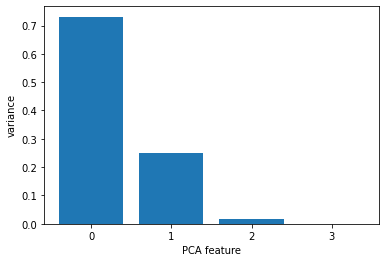

In [90]:
plt.bar(features, pca.explained_variance_ratio_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

In [92]:
# Principal component analysis (PCA) and singular value decomposition (SVD) 
# PCA and SVD are closely related approaches and can be both applied to decompose any rectangular matrices.
pca2 = PCA(n_components=2, svd_solver='full')
# fit PCA
pca2.fit(scaled)

# PCA transformed data
data_pca2 = pca2.transform(scaled)
print(data_pca2.shape)

(4172, 2)


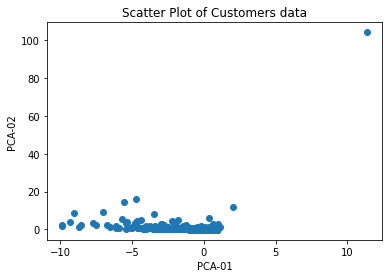

In [93]:
xs = data_pca2[:,0]
ys = data_pca2[:,1]
plt.scatter(ys, xs)

plt.grid(False)
plt.title('Scatter Plot of Customers data')
plt.xlabel('PCA-01')
plt.ylabel('PCA-02')

plt.show()

In [94]:
#  finding elbow value for different number of clusters.
X = data_pca2
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++',random_state= 42 ) )
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)   

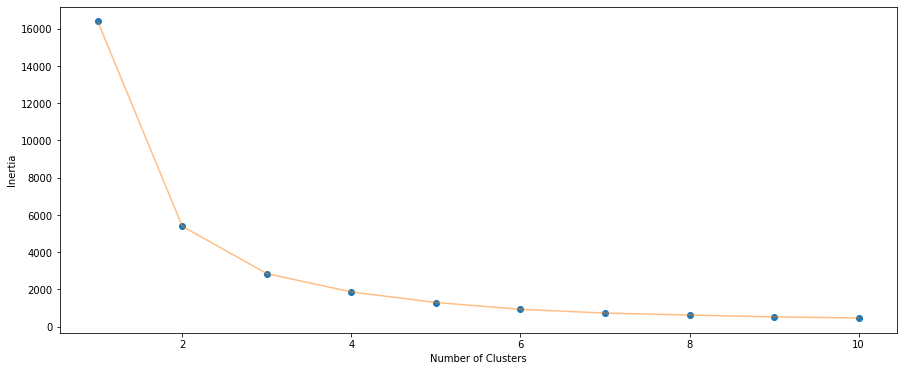

In [95]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [98]:
# KMeans model
# 5 clusters to start with
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans.fit(scaled)

KMeans(n_clusters=4, random_state=0)

In [99]:
labels = kmeans.labels_

In [100]:
new_df['cluster'] = labels
new_df['cluster'].value_counts()

0    3547
2     600
3      24
1       1
Name: cluster, dtype: int64

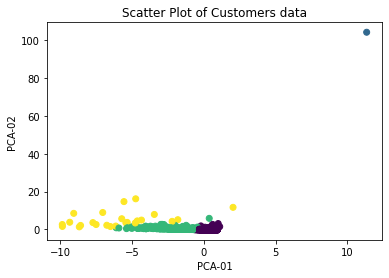

In [103]:
# Scatter plot visuals with labels

xs = data_pca2[:,0]
ys = data_pca2[:,1]
#zs = train_X.iloc[:,2]
plt.scatter(ys, xs,c=labels)
#plt.scatter(ys, zs, c=labels)

plt.grid(False)
plt.title('Scatter Plot of Customers data')
plt.xlabel('PCA-01')
plt.ylabel('PCA-02')

plt.show()

In [104]:
df_segm_analysis = new_df.groupby(['cluster']).mean()
df_segm_analysis

,predicted_purchases_4week,expected_avg_sales_,predicted_clv,profit_margin
cluster,,,,
0,0.201345,856.220530,2.237457e+03,111.872836
1,0.170000,871307.410000,1.681634e+06,84081.700000
2,0.820300,589.446900,6.870417e+03,343.520833
3,2.240833,7775.049167,1.107455e+05,5537.277083


In [110]:
# Add the segment labels to our table
new_df['Labels_PCA'] = new_df['cluster'].map({0:'Low',
                                          1:'Very-High',
                                          2:'High',
                                          3:'Medium'})

In [111]:
new_df.head()

,predicted_purchases_4week,expected_avg_sales_,predicted_clv,profit_margin,cluster,Labels,Labels_PCA
0,0.15,12508.15,58144.0,2907.20,0,Low,Low
1,0.44,696.06,4658.0,232.90,0,Low,Low
2,0.25,563.10,2213.0,110.65,0,Low,Low
3,0.16,1532.40,4141.0,207.05,0,Low,Low
6,0.51,376.32,2880.0,144.00,0,Low,Low


In [112]:
ggf_filter = pd.concat([ggf_filter,new_df['Labels_PCA']], axis = 1)

In [113]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases_4week,predicted_purchases_8week,predicted_purchases_12week,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Labels,Labels,Labels_PCA
0,12346,7.0,58.0,104.0,11066.637143,0.429333,0.570667,0.15,0.31,0.46,3.620690,3.470690,12508.15,58144.0,2907.20,Medium,Low,Low
1,12347,7.0,58.0,58.0,615.714286,0.000000,1.000000,0.44,0.89,1.33,3.620690,3.180690,696.06,4658.0,232.90,Low,Low,Low
2,12348,4.0,52.0,63.0,449.310000,0.024618,0.975382,0.25,0.50,0.74,2.307692,2.057692,563.10,2213.0,110.65,Low,Low,Low
3,12349,3.0,81.0,84.0,1120.056667,0.003997,0.996003,0.16,0.31,0.47,1.111111,0.951111,1532.40,4141.0,207.05,Low,Low,Low
6,12352,8.0,51.0,56.0,338.261250,0.011134,0.988866,0.51,1.02,1.52,4.705882,4.195882,376.32,2880.0,144.00,Low,Low,Low


In [114]:
ggf_filter.groupby('Labels_PCA').CustomerID.count()/ggf_filter.CustomerID.count()*100

Labels_PCA
High         14.381592
Low          85.019175
Medium        0.575264
Very-High     0.023969
Name: CustomerID, dtype: float64

In [115]:
ggf_filter.to_csv("Customer_Segmentation_result_PCA.csv")